# Implementing CNN network with a pretrained model (Tensorflow's [Mobile Net V2](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4)))

**import libs/dependencies**

In [1]:
import numpy as np
import cv2

import PIL
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from keras import layers
from keras import models

from google.colab import files

**Initialise shape of image**

In [2]:
IMAGE_SHAPE = (224,224)

## Get primary dataset to test model on
Note data used is a dataset of [flowers](https://www.tensorflow.org/tutorials/load_data/images)

In [3]:
dataset_url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, cache_dir='.', untar=True)

## Split images into lists based on flower type & define labels

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)
flowers_images = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*'))
}

**Flower labels & classes**

In [5]:
NUM_OUTPUTS = 5 # should correspond to number of labels!

flower_labels = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4
}
classes = {
    0: 'roses',
    1: 'daisy',
    2: 'dandelion',
    3: 'sunflowers',
    4: 'tulips'
}

## Reshape images

In [6]:
X, y = [], []
for flower_name, images in flowers_images.items():
  for image in images:
    img = cv2.imread(str(image))
    resized = cv2.resize(img, IMAGE_SHAPE)
    X.append(resized)
    y.append(flower_labels[flower_name])

In [7]:
X = np.array(X)
y = np.array(y)
X = X/255


## Custom plot function

Sample run: 


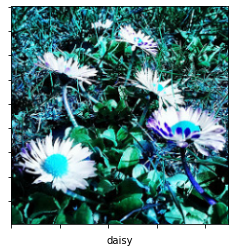

In [8]:
# X - List of images
# y - List of corresponding result labels
# index - display the image at the specified index
def plot(X, y, index):
  plt.imshow(X[index])
  ax = plt.gca()
  ax.axes.xaxis.set_ticklabels([])
  ax.axes.yaxis.set_ticklabels([])
  plt.xlabel(classes[y[index]])
print("Sample run: ")
plot(X, y, 777) # up till index 3669 (inclusive)

## **[OPTIONAL]**  Select a pre-trained model & test usage

Note: the section below is optional. It's for testing the use of a selected pre-trained model on a given dataset (specified in the [docs](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4))

Instructions (upload button at the bottom):
1. Upload a random picture of a toucan from online (save as: "toucan.jpg")
2. Upload a random picture of an earthstar from online (save as: "earthstar.jpg")
3. Upload the labels txt file **which the model was trained on**: [text labels](https://download.tensorflow.org/data/ImageNetLabels.txt) (save as: "ImageNetLabels.txt" which is the default name)

Note: by default data should be saved under /content (the PWD)

Model should successfully predict the uploaded images to be toucan and earthstar accordingly

In [ ]:
classifier = tf.keras.models.Sequential([
                                         # with a depth multiplier of 1.0 and an input size of 224x224 pixels and 3 channels
                                         hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE + (3,))
])

In [ ]:
files.upload()

earthstar = PIL.Image.open('earthstar.jpg').resize(IMAGE_SHAPE)
toucan = PIL.Image.open('toucan.jpg').resize(IMAGE_SHAPE)
earthstar = np.array(earthstar)/255.0
toucan = np.array(toucan)/255.0

# earthstar[np.newaxis, ...]

result_earthstar = classifier.predict(earthstar[np.newaxis, ...]) # classifier expects an array of images (in numpy form) as input 
result_toucan = classifier.predict(toucan[np.newaxis, ...])
predicted_label_earthstar = np.argmax(result_earthstar)
predicted_label_toucan = np.argmax(result_toucan)

image_labels = []
with open('ImageNetLabels.txt', 'r') as f:
  image_labels = f.read().splitlines()
# image_labels[:10] # observe what this line does

print("Predicted results for earthstar.jpg: " + image_labels[predicted_label_earthstar])
print("Predicted results for toucan.jpg: " + image_labels[predicted_label_toucan])

Predicted results for earthstar.jpg: earthstar
Predicted results for toucan.jpg: toucan


**[OPTIONAL]** This cell should run **only if** the above was executed.

Here, we use the selected pre-trained model to classify our dataset of flowers **but** notice because the output labels of the model is different from the one specific to the dataset, the model cannot give an appropriate output label.

Model's prediction: brassiere
Actual: 


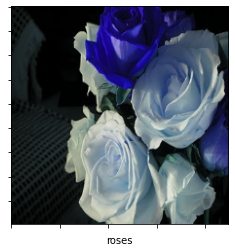

In [ ]:
pred = image_labels[np.argmax(classifier.predict(X[123][np.newaxis, ...]))]
print("Model's prediction: " + pred)
print("Actual: ")
plot(X, y, 123)

## Get test & train dataset

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Transfer Learning Model using previously selected classifier

What we want is the trained weights of the hidden layer while customising the final output layer to fit our problem's context (i.e every layer excluding last layer of prev model).

Note that **despite the significantly reduced number of epochs**, the accuracy in classification is almost similar, if not better, than previously (in cifar-cnn.ipynb). 

Network had been trained and hence only need a few epochs to customise its weights to the dataset.



In [10]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model = hub.KerasLayer(
    feature_extractor_model, input_shape = IMAGE_SHAPE + (3,), trainable=False)

cnn_tl = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dense(NUM_OUTPUTS) # output layer!
])
cnn_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

cnn_tl.fit(X_train, y_train, epochs = 7)

Epoch 1/7
86/86 [==============================] - 74s 817ms/step - loss: 0.8544 - acc: 0.6711
Epoch 2/7
86/86 [==============================] - 70s 814ms/step - loss: 0.4193 - acc: 0.8547
Epoch 3/7
86/86 [==============================] - 70s 815ms/step - loss: 0.3280 - acc: 0.8866
Epoch 4/7
86/86 [==============================] - 75s 868ms/step - loss: 0.2796 - acc: 0.9041
Epoch 5/7
86/86 [==============================] - 70s 814ms/step - loss: 0.2333 - acc: 0.9288
Epoch 6/7
86/86 [==============================] - 71s 820ms/step - loss: 0.2076 - acc: 0.9390
Epoch 7/7
86/86 [==============================] - 70s 814ms/step - loss: 0.1802 - acc: 0.9542


## Test & Evaluate

**Get results**
Note: <y_pred_classes> get the flower label prediction represented in number

In [11]:
y_pred = cnn_tl.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

**Evaluate**

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.74      0.81       176
           1       0.88      0.87      0.88       154
           2       0.94      0.88      0.91       226
           3       0.82      0.87      0.85       150
           4       0.77      0.91      0.84       212

    accuracy                           0.86       918
   macro avg       0.86      0.85      0.85       918
weighted avg       0.86      0.86      0.86       918



In [13]:
cnn_tl.evaluate(X_test, y_test)

29/29 [==============================] - 26s 871ms/step - loss: 0.4139 - acc: 0.8562


[0.4139363765716553, 0.8562091588973999]

**View results**

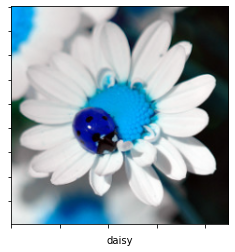

In [ ]:
idx = 123 # 0<= idx <= 917 (size of flower test set, by default 25% of total set)
plot(X_test, y_test, idx)

In [ ]:
classes[y_pred_classes[idx]]

'daisy'